Aim: subset the immune cells and re-integrate with scVI

In [1]:
# Import dependencies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import yaml
import scvi
import ray
import hyperopt
from ray import tune
from scvi import autotune

# Print date and time:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)

# Set other settings
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packag

Current date and time = 2024-12-16 16:17:39.964590
-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
aiohttp                     3.9.5
aiosignal                   1.3.1
annotated_types             0.5.0
anyio                       NA
arrow                       1.2.3
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      NA
bs4                         4.12.2
certifi                     2024.07.04
cffi                        1.15.1
charset_normalizer          3.2.0
chex                        0.1.83
click                       8.1.5
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.3
contextlib2                 NA
croniter                    NA
cycler                  

In [2]:
# set a working directory
wdir = '/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/'
os.chdir( wdir )

# create an output directory with today's date and time
year = e.strftime("%Y")
month = e.strftime("%m")
day = e.strftime("%d")
hour = e.strftime('%H')
minute = e.strftime('%M')
dmyt = f'{year}{month}{day}_{hour}-{minute}'
directory = f'{dmyt}_scVI_on_immune_subset.dir'

# folder structures
RESULTS_FOLDERNAME = f'{directory}/results/'
FIGURES_FOLDERNAME = f'{directory}/figures/'

if not os.path.exists(RESULTS_FOLDERNAME):
    os.makedirs(RESULTS_FOLDERNAME)
if not os.path.exists(FIGURES_FOLDERNAME):
    os.makedirs(FIGURES_FOLDERNAME)
    
# Set folder for saving figures into
sc.settings.figdir = FIGURES_FOLDERNAME

print(directory)

20241216_16-17_scVI_on_immune_subset.dir


In [3]:
path = os.path.join(wdir, 'data/integrated_objects/20240926_13-58_convert-objects.dir/Achilles_integrated_annotated.h5ad')
path

'/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/data/integrated_objects/20240926_13-58_convert-objects.dir/Achilles_integrated_annotated.h5ad'

### Read in adata object
This Achilles data object has been integrated using scVI, then taken back into R and annotated.

In [4]:
adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'lo

In [5]:
# scvi works with raw counts
adata.X = adata.layers['counts'].copy()

In [6]:
# subset to immune cells
fibroblasts = ['Macrophages','Granulocytes', 'T cells', 'B cells', 'B plasma cells']
adata_mac = adata[adata.obs['cell_annotation_scVI_0.2'].isin(fibroblasts)].copy()
adata_mac

AnnData object with n_obs × n_vars = 7143 × 61552
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'lou

In [7]:
adata_mac.obs['cell_annotation_scVI_0.2']

MSK0785-Ach-Enth_AATTTCCAGGTTACCT    Macrophages
MSK0785-Ach-Enth_ACACGCGAGTGCAGGT        T cells
MSK0785-Ach-Enth_ACCACAACATCCTCAC        T cells
MSK0785-Ach-Enth_ACTCCCAGTACCAATC    Macrophages
MSK0785-Ach-Enth_AGAACCTTCCACTGGG    Macrophages
                                        ...     
MSK1691-ACH-MTJ_TTTCACAGTTTGAACC         T cells
MSK1691-ACH-MTJ_TTTCATGCATGGGCAA         T cells
MSK1691-ACH-MTJ_TTTCGATGTGACTGAG     Macrophages
MSK1691-ACH-MTJ_TTTCGATGTGTCTTCC     Macrophages
MSK1691-ACH-MTJ_TTTGTTGGTAGGGAGG     Macrophages
Name: cell_annotation_scVI_0.2, Length: 7143, dtype: category
Categories (5, object): ['Macrophages', 'T cells', 'Granulocytes', 'B cells', 'B plasma cells']

In [8]:
adata_mac.obs_names_make_unique()

In [9]:
# calculate 2000 hvg and subset to those genes
sc.pp.highly_variable_genes(adata_mac, 
                            n_top_genes= 2000, 
                            flavor='seurat_v3', 
                            batch_key='patient.seqbatch',
                            subset = True, 
                           span=1) # increase from default of 0.3 to avoid error

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [10]:
adata_mac

AnnData object with n_obs × n_vars = 7143 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_soupX', 'nFeature_soupX', 'patient.seqbatch', 'louvain_soupX_snn_res.0.1', 'louvain_soupX_snn_res.0.2', 'louvain_soupX_snn_res.0.3', 'louvain_soupX_snn_res.0.4', 'louvain_soupX_snn_res.0.5', 'louvain_soupX_snn_res.0.6', 'louvain_soupX_snn_res.0.7', 'louv

### Optimise the scVI model using ray

In [11]:
# set up the object and view the available paramaters that can be tuned

model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata_mac, layer="counts", 
                        batch_key='patient.seqbatch')

scvi_tuner = autotune.ModelTuner(model_cls)
scvi_tuner.info()

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [12]:
# specify which variables will be tested
search_space = {
    "n_latent": tune.choice([10, 30, 50]),
    "n_hidden": tune.choice([60, 128, 256]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])
}

In [13]:
ray.init(log_to_driver=False)

2024-12-16 16:17:48,042	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.9.16
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8266


In [14]:
# run the optimisation

results = scvi_tuner.fit(
    adata_mac,
    metric="validation_loss",
    search_space=search_space,
    searcher='hyperopt',
    num_samples=100,
    max_epochs=30,
    resources={"gpu": 1}
)

2024-12-16 16:17:49,251	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-12-16 16:20:48,372	INFO tune.py:1143 -- Total run time: 179.12 seconds (179.07 seconds for the tuning loop).


We are looking for the parameters that give the lowest validation loss

In [15]:
print(results.model_kwargs)
print(results.train_kwargs)

{'n_latent': 50, 'n_hidden': 256, 'n_layers': 1, 'gene_likelihood': 'zinb'}
{'plan_kwargs': {'lr': 0.002238500801672889}}


In [16]:
df = results.results.get_dataframe()
df2 = df.sort_values(by = 'validation_loss').reset_index()
df2

,index,validation_loss,timestamp,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/n_latent,config/n_hidden,config/n_layers,config/lr,config/gene_likelihood,logdir
0,82,6.662862e+02,1734366018,False,30,b3bf5239,2024-12-16_16-20-18,0.478752,13.684700,3719210,...,163.1.64.158,13.684700,30,None,50,256,1,0.002239,zinb,b3bf5239
1,44,6.672924e+02,1734365962,False,30,069e949e,2024-12-16_16-19-22,0.416727,12.720630,3720121,...,163.1.64.158,12.720630,30,None,50,256,1,0.002593,nb,069e949e
2,65,6.693911e+02,1734365998,False,30,167a0d4d,2024-12-16_16-19-58,0.413824,12.733091,3720121,...,163.1.64.158,12.733091,30,None,50,256,1,0.003089,nb,167a0d4d
3,94,6.717672e+02,1734366031,False,30,d7803e2a,2024-12-16_16-20-31,0.470318,12.776811,3719210,...,163.1.64.158,12.776811,30,None,50,256,1,0.002382,nb,d7803e2a
4,99,6.765114e+02,1734366048,False,30,3514a747,2024-12-16_16-20-48,0.451351,14.380087,3719210,...,163.1.64.158,14.380087,30,None,50,256,1,0.001881,zinb,3514a747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,86,1.313947e+03,1734366007,True,1,833fdeae,2024-12-16_16-20-07,0.555368,0.555368,3720121,...,163.1.64.158,0.555368,1,None,50,256,2,0.006060,zinb,833fdeae
96,21,1.319479e+03,1734365904,True,1,165389a2,2024-12-16_16-18-24,0.554480,0.554480,3720121,...,163.1.64.158,0.554480,1,None,50,256,1,0.008876,nb,165389a2
97,31,1.341590e+03,1734365930,True,1,c650532a,2024-12-16_16-18-50,0.532967,0.532967,3719210,...,163.1.64.158,0.532967,1,None,50,256,1,0.009880,nb,c650532a
98,52,3.110711e+03,1734365964,True,1,3ce61b75,2024-12-16_16-19-24,0.555935,0.555935,3720121,...,163.1.64.158,0.555935,1,None,50,256,3,0.009930,nb,3ce61b75


In [17]:
print("Index of optimal parameters")
row_number = df2['index'][0]
row_number

Index of optimal parameters


82

In [18]:
print("Optimal parameters")
df.iloc[row_number]

Optimal parameters


validation_loss                      666.286194
timestamp                            1734366018
done                                      False
training_iteration                           30
trial_id                               b3bf5239
date                        2024-12-16_16-20-18
time_this_iter_s                       0.478752
time_total_s                            13.6847
pid                                     3719210
hostname                            BRC-89SJ904
node_ip                            163.1.64.158
time_since_restore                      13.6847
iterations_since_restore                     30
checkpoint_dir_name                        None
config/n_latent                              50
config/n_hidden                             256
config/n_layers                               1
config/lr                              0.002239
config/gene_likelihood                     zinb
logdir                                 b3bf5239
Name: 82, dtype: object

In [19]:
ray.shutdown()

### Run scVI using optimised parameters



In [20]:
# set up the adata object
scvi.model.SCVI.setup_anndata(adata_mac,
                              layer = 'counts',
                              batch_key = "patient.seqbatch"
                             )

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [21]:
# set up the scVI model
# specify the parameters according to the ray optimisation
vae = scvi.model.SCVI(adata_mac,
                      n_latent = 50,  
                      n_hidden = 256, 
                      n_layers =  1, 
                      dropout_rate = 0.1,
                      dispersion = 'gene-batch',
                     gene_likelihood='zinb')

vae

SCVI Model with the following params: 
n_hidden: 256, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [22]:
# add the parameter for lr
kwargs = {'lr': 0.002239}

In [23]:
 vae.view_anndata_setup(adata_mac) # check the set up looks as expected

Anndata setup with scvi-tools version 1.0.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'patient.seqbatch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   8   │
│         n_cells          │ 7143  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient.seqbatch'] │ MSK0785_11102021 │          0          │
│                               │ MSK1250_11102021 │          1          │
│                               │ MSK1250_20230822 │          2          │
│                               │ MSK1284_11102021 │          3          │
│                               │ MSK1556_20220808 │          4          │
│                               │ MSK1556_20230822 │          5          │
│                               │ MSK1687_20230822 │          6          │
│                               │ MSK1691_20230822 │          7          │
└───────────────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [24]:
# calculate the number of epochs needed which varies according to the cell number
max_epochs_scvi = int(np.min([round((20000 / adata_mac.n_obs) * 400), 400])) # must be an integer
max_epochs_scvi

400

In [25]:
# run the training (need the GPU queue here)
# updated to 60 epochs due to overfitting
vae.train(max_epochs = 60, 
          train_size = 0.9, 
          validation_size = 0.1, 
          accelerator='gpu', 
          check_val_every_n_epoch=1,
          early_stopping=True,
          early_stopping_patience=10,
          early_stopping_monitor="elbo_validation",
          plan_kwargs = kwargs
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 48/60:  80%|███████████████████████▏     | 48/60 [00:22<00:05,  2.15it/s, v_num=1, train_loss_step=611, train_loss_epoch=630]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 766.736. Signaling Trainer to stop.


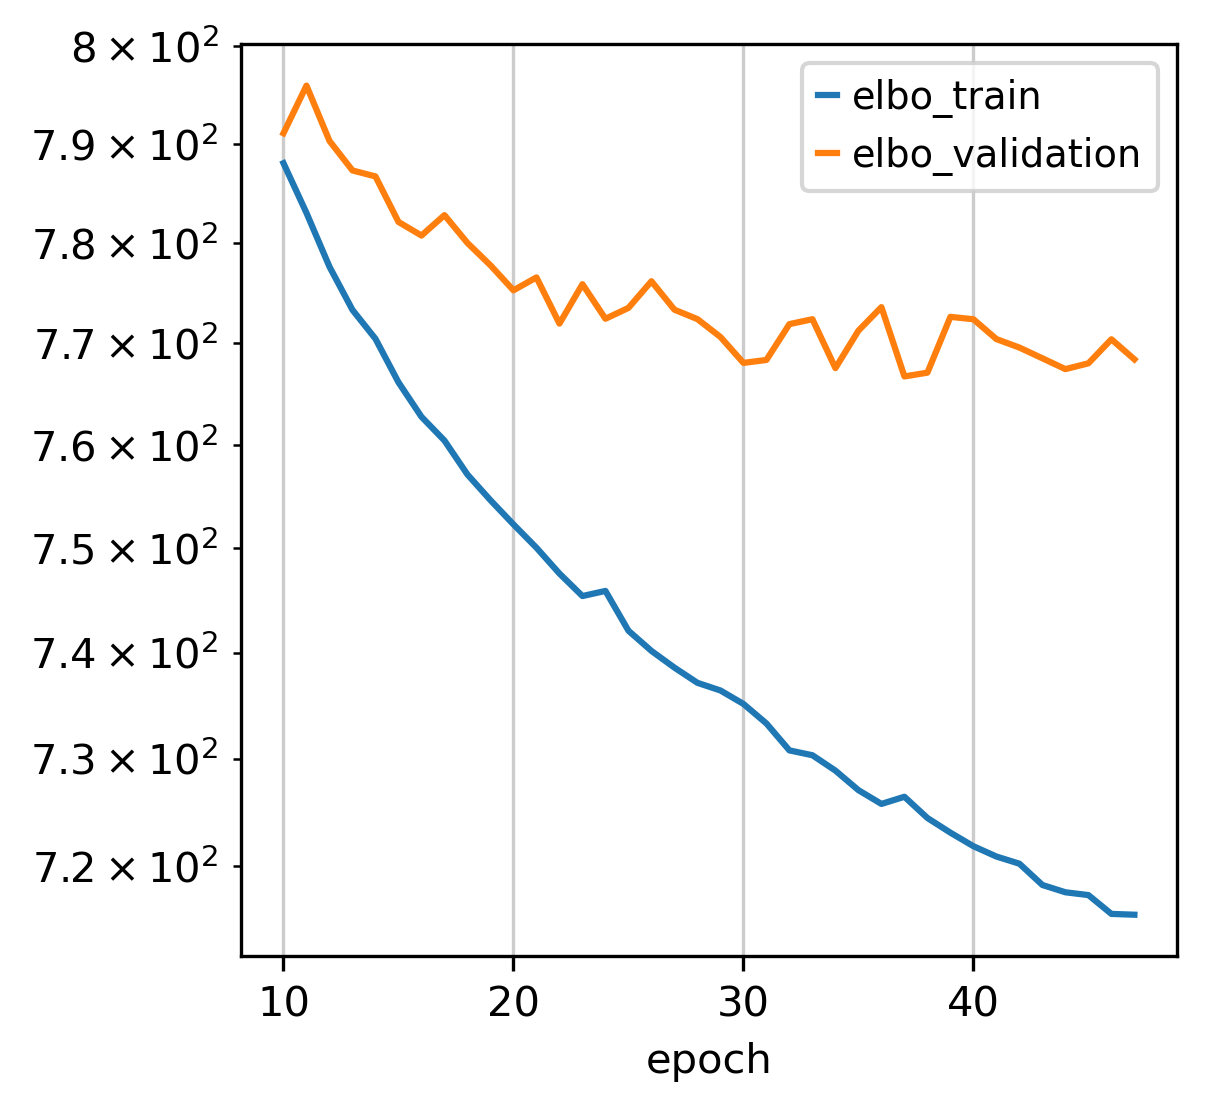

In [26]:
# visualise the results of the training
train_test_results = vae.history["elbo_train"]
train_test_results["elbo_validation"] = vae.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

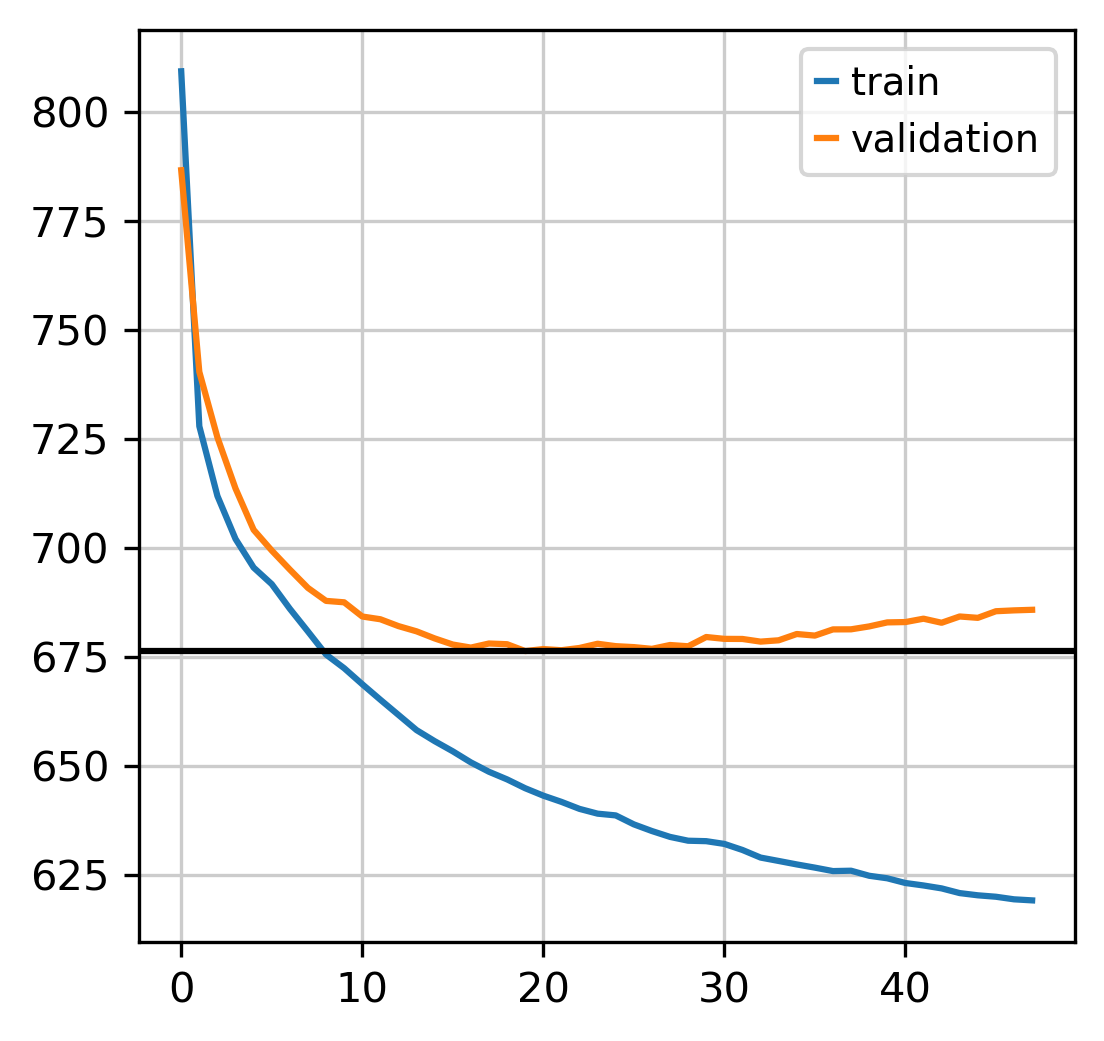

In [27]:
y = vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.axhline(y, c = 'k')
plt.legend()
plt.show()

In [28]:
# save the trained model
# in file name use: sample, covariate, nepochs, n_hidden, n_latent, n_layers, dropout rate, dispersion, gene likelihood
vae.save(os.path.join(RESULTS_FOLDERNAME, "Ach_patient.seqbach_60_256_50_1_01_gene-batch_zinb/"), overwrite=True)

In [29]:
# Extract latent representation embeddings from your trained model 
adata_mac.obsm["X_scVI"] = vae.get_latent_representation()

In [30]:
# save the object
adata_mac.write(os.path.join(RESULTS_FOLDERNAME, 'Achilles_scVI.h5ad'))

In [31]:
# Save the scVI embeddings as numpy array
filename = RESULTS_FOLDERNAME + "scVI_embeddings"
np.save(filename, adata_mac.obsm['X_scVI'])

In [32]:
# Save the metadata
filename = RESULTS_FOLDERNAME + "Achilles_scVI_obs.txt"
adata_mac.obs.to_csv(filename, sep='\t')